# &#x1F4DD; REPORT

## &#x0031;&#xFE0F;&#x20E3; PRACH Uplink Signal

&#x1F5D2; 61.44 Ms/s, 5G NR PRACH Format 0
- here $N_{zc} = 839$ This is $L_{RA}$ in 5G
- OFDM Symbol Size => 49152 Samples
- Cyclic prefix Lenght => 3168*2 = 6336 samples
- ZeroCorrelationZoneConfig = 5 ( $N_{cs} = 26$)

&#x1F5D2; RX Signal 1 (rxsig1)
- Single UE transmission with noise + channel

&#x1F5D2; RX Signal 2 (rxsig2)
- Multi-UE transmission with noise + channel

In [1]:
using FFTW
using DSP

In [2]:
## Load the useful math operations
include("../modules/operations.jl");

In [3]:
# this is a 5G PRACH format 0 transmission
Lᵣₐ=839

# this is number of samples per bin, floor(L/Ncs) gives the number of cyclic shifts, see below
Ncs=26
# this is the FFT size for the generation/reception of PRACH
N=49152
# this is the length of the cyclic prefix for PRACH
Ncp=6336;

In [4]:
# 6-bit data messages for 3 transmitters / UEs
preamble = [ 63, 31, 11];

# up to 6 Zadoff-Chu root sequences for this format
utab=[129 710 140 699 120 719]; @show length(utab);

length(utab) = 6


In [5]:
# number of cyclic shifts
nshifts = floor(Int, Lᵣₐ / Ncs)
# number of Zadoff-Chu sequences required
nseq = ceil(Int, 64 / nshifts);

In [6]:
# index of the preamble sequence to use
uind1 = div(preamble[1], nshifts)
uind2 = div(preamble[2], nshifts)
uind3 = div(preamble[3], nshifts)

# index of cyclic shift to use
nuind1 = rem(preamble[1], nshifts)
nuind2 = rem(preamble[2], nshifts)
nuind3 = rem(preamble[3], nshifts)

# Check if indices are within the range of utab
if (uind1 >= length(utab) || uind2 >= length(utab) || uind3 >= length(utab))
    println("ERROR tab length ", length(utab), " : ", uind1, " ", uind2, " ", uind3)
end

In [7]:
# These are the Zadoff-Chu Sequence generators (time-domain) 
# for the 3 transmitters
xu1 = exp.(-im * π * utab[1 + uind1] * collect(0:(Lᵣₐ - 1)) .* collect(1:Lᵣₐ) / Lᵣₐ)
xu2 = exp.(-im * π * utab[1 + uind2] * collect(0:(Lᵣₐ - 1)) .* collect(1:Lᵣₐ) / Lᵣₐ)
xu3 = exp.(-im * π * utab[1 + uind3] * collect(0:(Lᵣₐ - 1)) .* collect(1:Lᵣₐ) / Lᵣₐ)
@show size(xu1), size(xu2), size(xu3);

(size(xu1), size(xu2), size(xu3)) = ((839,), (839,), (839,))


In [8]:
# implement cyclic-shifts
# Note: In practice, it's not common to do cyclic shifts in the time-domain and then perform FFT.
# There is a way to compute the Fourier transform directly and then perform the cyclic shift by a multiplication of a phasor in the frequency-domain.

yuv1 = zeros(Complex{Float64}, length(xu1))
yuv2 = zeros(Complex{Float64}, length(xu2))
yuv3 = zeros(Complex{Float64}, length(xu3))

# Assuming length(xu1), length(xu2), and length(xu3) are known
xuv1 = zeros(ComplexF64, length(xu1))
xuv2 = zeros(ComplexF64, length(xu2))
xuv3 = zeros(ComplexF64, length(xu3))

for n = 0:(Lᵣₐ - 1)
    xuv1[n + 1] = xu1[1 + rem(n + (Ncs * nuind1), Lᵣₐ)]
    yuv1 .+= fft(xuv1)
    
    xuv2[n + 1] = xu2[1 + rem(n + (Ncs * nuind2), Lᵣₐ)]
    yuv2 .+= fft(xuv2)
    
    xuv3[n + 1] = xu3[1 + rem(n + (Ncs * nuind3), Lᵣₐ)]
    yuv3 .+= fft(xuv3)
end

In [9]:
# put the PRACH in the lowest frequency (positive) subcarriers starting at carrier 7
Xuv1 = zeros(Complex{Float64}, N)
Xuv1[7 .+ (1:Lᵣₐ)] .= yuv1

Xuv2 = zeros(Complex{Float64}, N)
Xuv2[7 .+ (1:Lᵣₐ)] .= yuv2

Xuv3 = zeros(Complex{Float64}, N)
Xuv3[7 .+ (1:Lᵣₐ)] .= yuv3;

In [10]:
# bring to time-domain
xuv1_49152 = 𝓕⁻¹(Xuv1)
xuv2_49152 = 𝓕⁻¹(Xuv2)
xuv3_49152 = 𝓕⁻¹(Xuv3)
@show size(xuv1_49152), size(xuv2_49152), size(xuv3_49152);

(size(xuv1_49152), size(xuv2_49152), size(xuv3_49152)) = ((49152,), (49152,), (49152,))


In [11]:
using Plots
using LinearAlgebra

In [12]:
# add cyclic prefix
xuv1_49152 = [xuv1_49152[(end - (Ncp - 1)):end]; xuv1_49152]
xuv2_49152 = [xuv2_49152[(end - (Ncp - 1)):end]; xuv2_49152]
xuv3_49152 = [xuv3_49152[(end - (Ncp - 1)):end]; xuv3_49152];

In [13]:
using StatsBase

In [14]:
# normalizes the transmit signal to unit-energy
xuv1_49152 /= sqrt(sum(abs2.(xuv1_49152)) / length(xuv1_49152))
en1 = mean(abs2.(xuv1_49152))
xuv2_49152 /= sqrt(sum(abs2.(xuv2_49152)) / length(xuv2_49152))
en2 = mean(abs2.(xuv2_49152))
xuv3_49152 /= sqrt(sum(abs2.(xuv3_49152)) / length(xuv3_49152))
en3 = mean(abs2.(xuv3_49152))

1.0

In [15]:
# simulate time-delay
delay = [300, 140, 40]
delaymax = 1 + maximum([delay[1], delay[2], delay[3]])

xuv1_49152 = vcat(vec(zeros(ComplexF64, 1, delay[1])), xuv1_49152, vec(zeros(ComplexF64, 1, delaymax - delay[1])))
xuv2_49152 = vcat(vec(zeros(ComplexF64, 1, delay[2])), xuv2_49152, vec(zeros(ComplexF64, 1, delaymax - delay[2])))
xuv3_49152 = vcat(vec(zeros(ComplexF64, 1, delay[3])), xuv3_49152, vec(zeros(ComplexF64, 1, delaymax - delay[3])))
@show length(xuv1_49152), length(xuv2_49152), length(xuv3_49152);

(length(xuv1_49152), length(xuv2_49152), length(xuv3_49152)) = (55789, 55789, 55789)


In [16]:
using Random

In [17]:
SNR = 0
snr = 10^(0.1 * SNR)

# Generate complex Gaussian noise
noise1 = √(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)))
noise2 = √(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)));

In [18]:
# Add noise to signals
rxsig1 = xuv1_49152 + noise1
rxsig2 = xuv1_49152 + xuv2_49152 + xuv3_49152 + noise2;

&#x1F5D2; Plotting the beginning of RX Signal 1 (rxsig1) 

In [19]:
rxsig1_plot =
plot(20 * log10.(abs.(𝓕(rxsig1)))
    , size = ( 800, 300 )
    , linewidth = .5
    , xlims = (1, 1024)  # Set x-axis limits
    , ylims = (30, 80)   # Set y-axis limits
    , xlabel="Frequency Bin", ylabel="Magnitude (dB)", title="FFT Magnitude in dB"
)
savefig(rxsig1_plot, "images/rxsig1_plot.png");

![title](images/rxsig1_plot.png)

&#x1F5D2; Plotting the full of RX Signal 1 (rxsig1) 

In [20]:
rxsig1_full_plot =
plot(20 * log10.(abs.(𝓕(rxsig1)))
    , size = ( 800, 300 )
    , linewidth = .5
    , xlabel="Frequency Bin", ylabel="Magnitude (dB)", title="FFT Magnitude in dB"
)
savefig(rxsig1_full_plot, "images/rxsig1_full_plot.png");

![title](images/rxsig1_full_plot.png)

&#x1F5D2; Plotting the beginning of RX Signal 2 (rxsig2) 

In [21]:
rxsig2_plot =
plot(20 * log10.(abs.(𝓕(rxsig2)))
    , size = ( 800, 300 )
    , linewidth = .5
    , xlims = (1, 1024)  # Set x-axis limits
    , ylims = (30, 80)   # Set y-axis limits
    , xlabel="Frequency Bin", ylabel="Magnitude (dB)", title="FFT Magnitude in dB"
)
savefig(rxsig2_plot, "images/rxsig2_plot.png");

![title](images/rxsig2_plot.png)

&#x1F5D2; Plotting the full of RX Signal 2 (rxsig2) 

In [22]:
rxsig2_full_plot =
plot(20 * log10.(abs.(𝓕(rxsig2)))
    , size = ( 800, 300 )
    , linewidth = .5
    , xlabel="Frequency Bin", ylabel="Magnitude (dB)", title="FFT Magnitude in dB"
)
savefig(rxsig2_full_plot, "images/rxsig2_full_plot.png");

![title](images/rxsig2_full_plot.png)

&#x1F516; a) implement the receiver using a frequency-domain correlation

   using the Zadoff-Chu sequences generation method as above


In [23]:
rxsig1_noprefix = rxsig1[Ncp:Ncp+(N - 1)]
rxsig2_noprefix = rxsig2[Ncp:Ncp+(N - 1)];

In [24]:
RXSIG1 = 𝓕(rxsig1_noprefix); # bring to Frequency Domain
RXSIG2 = 𝓕(rxsig2_noprefix); # bring to Frequency Domain

In [25]:
utab[1]

129

In [26]:
# correlation with preamble sequence with nu=0 for each sequence
nseq = length(utab)
Xu = zeros(ComplexF64, nseq, Lᵣₐ)
Ru1 = similar(Xu)
Ru2 = similar(Xu)
ru1 = similar(Xu)
ru2 = similar(Xu)

for seq in 1:nseq
    # Compute time-domain ZC sequence for each u in 1:nseq
    xun = exp.(-1π * im * utab[seq] * (0:(Lᵣₐ - 1)) .* (1:Lᵣₐ) / Lᵣₐ)#; @show typeof(xun)#, xun
    
    # Compute freq-domain ZC sequence for each u in 1:nseq
    Xu[seq,:] = 𝓕(xun) # bring to fft
    
    # Correlate (componentwise multiplication and IFFT) with received signal
    Ru1[seq, :] = RXSIG1[7 .+ (1:Lᵣₐ)] .* (Xu[seq, :])ˣ
    Ru2[seq, :] = RXSIG2[7 .+ (1:Lᵣₐ)] .* (Xu[seq, :])ˣ
    ru1[seq, :] = 𝓕⁻¹(Ru1[seq, :]) # back to Time-Domain
    ru2[seq, :] = 𝓕⁻¹(Ru2[seq, :]) # back to Time-Domain
end


## &#x1F4C9; Plotting

&#x1F516; b) show how the data detection and time-delay estimation

&#x1F5D2; RX Signal 1 (rxsig1)
- Single UE transmission with noise + channel



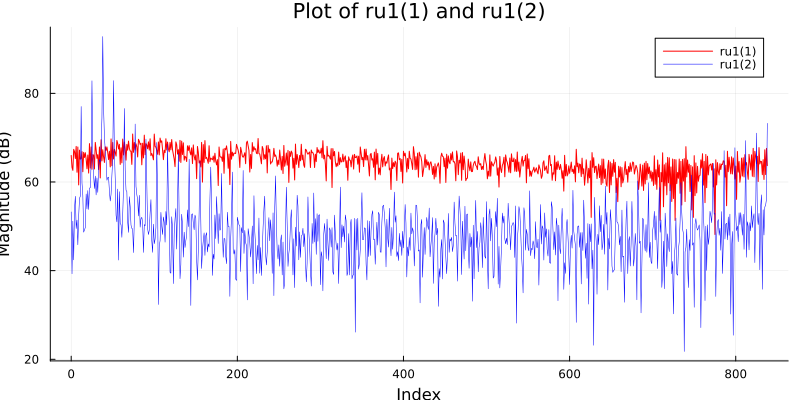

In [27]:
plot(0:838, 20 * log10.(abs.(ru1[1, :]))
    , label="ru1(1)", color=:red
    , xlabel = "Index", ylabel = "Magnitude (dB)"
    , title = "Plot of ru1(1) and ru1(2)"
    , size = (800, 400)
    , linewidth = 1
)
plot!(0:838, 20 * log10.(abs.(ru1[2, :]))
    , label="ru1(2)", color=:blue
    , linewidth = .5
)

&#x1F5D2; RX Signal 2 (rxsig2)
- Multi-UE transmission with noise + channel
- notice the 2 red peaks

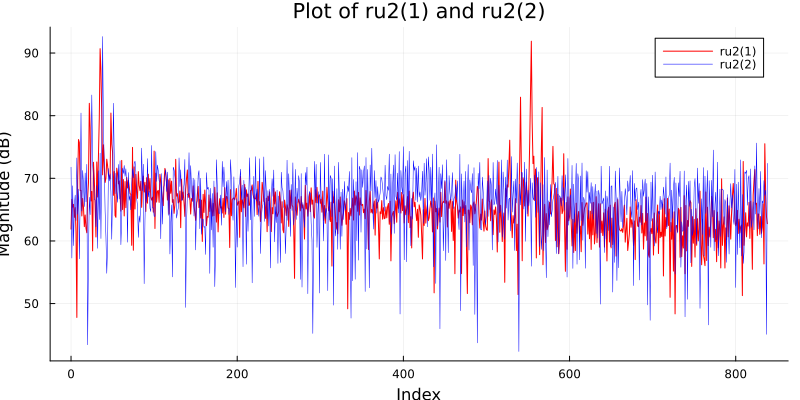

In [28]:
plot(0:838, 20 * log10.(abs.(ru2[1, :]))
    , label="ru2(1)", color=:red
    , xlabel = "Index", ylabel = "Magnitude (dB)"
    , title = "Plot of ru2(1) and ru2(2)"
    , size = (800, 400)
    , linewidth = 1
)
plot!(0:838, 20 * log10.(abs.(ru2[2, :]))
    , label="ru2(2)", color=:blue
    , linewidth = .5
)